The following code blocks have been sourced or adapted from

[10] T. M. Ngo, “tuengominh/deap-eeg-classification.” Apr. 12, 2023. Accessed: Apr. 16, 2023. [Online]. Available: https://github.com/tuengominh/deap-eeg-classification/blob/b7c720e9ea1c37241b2b336d33d1d9830c17a8bf/eeg_based_emotion_classification.ipynb


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

#!pip install scikit-learn==0.20.3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

!pip install mne==0.22.0
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

!pip install fooof
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 11.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 3.6 MB/s eta 0:00:00


## Load Dataset

In [ ]:
sohas_base_path = '/content/gdrive/MyDrive/BME 4B/SYDE 544/SYDE544 - Project/DEAP Dataset/'
aarzoos_base_path = '/content/gdrive/MyDrive/4B/SYDE544/SYDE544 - Project (1)/DEAP Dataset/'
elizabeths_base_path = '/content/gdrive/MyDrive/SYDE 544/SYDE544- Project/DEAP Dataset/'
# sonalis_base_path = '/content/gdrive/MyDrive/Waterloo/Waterloo 4B Term/SYDE544 - Project/DEAP Dataset/'

# base_path = sohas_base_path
# base_path = aarzoos_base_path
# base_path = sonalis_base_path
base_path = elizabeths_base_path
dat_files_path = os.path.join(base_path, 'data_preprocessed_python')
print(dat_files_path)


/content/gdrive/MyDrive/SYDE 544/SYDE544- Project/DEAP Dataset/data_preprocessed_python


In [ ]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [ ]:
# 32x40 = 1280 trials for 32 participants
# 128 Hz x 63 seconds (60s stimulus + 3s baseline?) = 8064 samples
labels = []
data = []

for sub_dat_file in os.listdir(dat_files_path):
  # print(sub_dat_file)
  filename = os.path.join(dat_files_path, sub_dat_file)
  trial = read_eeg_signal_from_file(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])

# Re-shape arrays into desired shapes
# Order is in order of video ID (not in which way they were presented to the participant)
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(1280, 4)

data = np.array(data)
data = data.flatten()
data = data.reshape(1280, 40, 8064)

In [ ]:
# Double-check the new arrays
print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (1280, 4)
Data:  (1280, 40, 8064)


In [ ]:
# Only extract Liking ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0]})
# print(df_label_ratings.head())
# print(df_label_ratings.describe())

In [ ]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0 

# Convert valence to binary 0 (low), 1 (high)
valence_labels_encoded = []
for i in range (len(labels)):
  valence_labels_encoded.append(positive_valence(i))
valence_labels_encoded = np.reshape(valence_labels_encoded, (1280))

## EEG Data

https://www.researchgate.net/figure/Comparison-of-electrode-placement-between-MUSE-and-the-international-10-20-system-a_fig2_352019337
We'll use
* AF7 --> AF3 (channel 2)
* AF8 --> AF4 (channel 18)
* TP9 --> T7 (channel 8)
* TP10 --> T8 (channel 26)

In [ ]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [ ]:
# params
fs = 128
num_desired_channels = 4
# num_desired_channels = len(eeg_channels)
n_samples = fs * 60

# Extract our desired channels
# Also segment the middle 30s
# Taking t_start = 3s + 15s to t_end  = t_start + 30s 
eeg_data = []

# for middle 30 s
# t_start_seg = (fs * (3 + 15)) - 1
# t_end_seg = t_start_seg + (fs * 30)

# for full 60s
t_start_seg = (fs * 3) - 1
t_end_seg = t_start_seg + (fs * 60)


for i in range (len(data)):
  # AF3 (channel 2)
  eeg_data.append(data[i,1,t_start_seg:t_end_seg])

  # T7 (channel 8)
  eeg_data.append(data[i,7,t_start_seg:t_end_seg])

  # AF4 (channel 18)
  eeg_data.append(data[i,17,t_start_seg:t_end_seg])

  # T8 (channel 26)
  eeg_data.append(data[i,25,t_start_seg:t_end_seg])

# # Testing with using all EEG channels to see baseline accuracy 
# for i in range (len(data)):
#   for j in range (len(eeg_channels)):
#     eeg_data.append(data[i, j, t_start_seg:t_end_seg])

eeg_data = np.reshape(eeg_data, (len(data), num_desired_channels, n_samples))
print(eeg_data.shape)

(1280, 4, 7680)


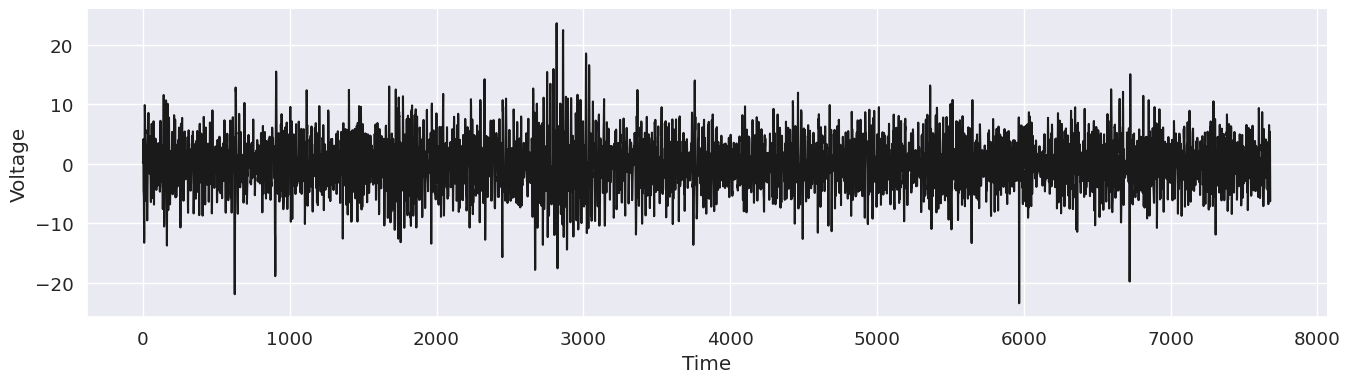

In [ ]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
time = np.arange(eeg_data.size) / sf

# Plot the signal of first trial, first channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
#signal of first trail, last channel
plt.plot(eeg_data[0,0], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

4


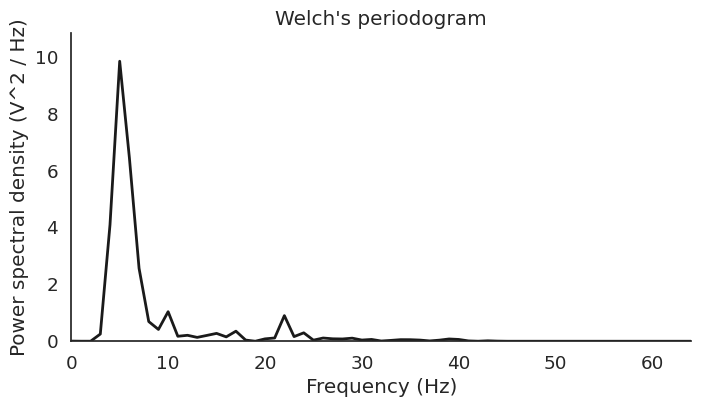

In [ ]:
print(num_desired_channels)

sf = 128
#defined window of 1 second
win = 1*sf
times = list(range(0, 61))
times_sf = [i * 128 for i in times]
freqs, psd = signal.welch(eeg_data[0,0, times_sf[29]:times_sf[30]], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

In [ ]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 1.982 uV^2


In [ ]:
def get_all_powers(freqs, psd):

  # Define delta lower and upper limits
  delta_l, delta_h = 0.5, 4
  theta_l, theta_h = 4, 8
  alpha_l, alpha_h = 8, 12
  beta_l, beta_h = 12, 30

  # Find intersecting values in frequency vector
  idx_delta = np.logical_and(freqs >= delta_l, freqs <= delta_h)
  idx_theta = np.logical_and(freqs >= theta_l, freqs <= theta_h)
  idx_alpha = np.logical_and(freqs >= alpha_l, freqs <= alpha_h)
  idx_beta = np.logical_and(freqs >= beta_l, freqs <= beta_h)
  # Frequency resolution
  freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

  # Compute the absolute power by approximating the area under the curve
  # multiplied by 100000 for microVolts
  delta_power = simps(psd[idx_delta], dx=freq_res) * 100000
  theta_power = simps(psd[idx_theta], dx=freq_res) * 100000
  alpha_power = simps(psd[idx_alpha], dx=freq_res) * 100000
  beta_power = simps(psd[idx_beta], dx=freq_res) * 100000

  return delta_power, theta_power, alpha_power, beta_power

In [ ]:
# preprocessing for bandpower per fequecy 
delta = np.empty((1280, 4, 60))
theta = np.empty((1280, 4, 60))
alpha = np.empty((1280, 4, 60))
beta = np.empty((1280, 4, 60))

# times = list(range(0, 31))
# times_sf = [i * 128 for i in times]

sf = 128
#defined window of 1 second
win = 1*sf

for trial in range(eeg_data.shape[0]):
  #print("trial: ", trial, " channel: ", channel, " second: ", second)
  for channel in range(eeg_data.shape[1]):
    for second in range(len(times_sf)-1):
      
      first = times_sf[second]
      last = times_sf[second+1]
      #print("first: ", first, " last: ", last)
      freqs, psd = signal.welch(eeg_data[trial, channel, first:last], sf, nperseg=win)

      d_power, t_power, a_power, b_power = get_all_powers(freqs, psd)
      #d_power, t_power = get_all_powers(freqs, psd)
      delta[trial, channel, second] = d_power
      theta[trial, channel, second] = t_power
      alpha[trial, channel, second] = a_power
      beta[trial, channel, second] = b_power

In [ ]:
print(alpha.shape)

(1280, 4, 60)


## Test, train split

In [ ]:
# Split the data into training/testing sets
def split_train_test(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
  return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = split_train_test(eeg_data, valence_labels_encoded)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(896, 4, 7680)
(384, 4, 7680)
(896,)
(384,)


In [ ]:
delta_x_train, delta_x_test, delta_y_train, delta_y_test = split_train_test(delta, valence_labels_encoded)

print(delta_x_train.shape)
print(delta_x_test.shape)
print(delta_y_train.shape)
print(delta_y_test.shape)

(896, 4, 60)
(384, 4, 60)
(896,)
(384,)


In [ ]:
theta_x_train, theta_x_test, theta_y_train, theta_y_test = split_train_test(theta, valence_labels_encoded)

print(theta_x_train.shape)
print(theta_x_test.shape)
print(theta_y_train.shape)
print(theta_y_test.shape)

(896, 4, 60)
(384, 4, 60)
(896,)
(384,)


In [ ]:
alpha_x_train, alpha_x_test, alpha_y_train, alpha_y_test = split_train_test(alpha, valence_labels_encoded)

print(alpha_x_train.shape)
print(alpha_x_test.shape)
print(alpha_y_train.shape)
print(alpha_y_test.shape)

(896, 4, 60)
(384, 4, 60)
(896,)
(384,)


In [ ]:
beta_x_train, beta_x_test, beta_y_train, beta_y_test = split_train_test(beta, valence_labels_encoded)

print(beta_x_train.shape)
print(beta_x_test.shape)
print(beta_y_train.shape)
print(beta_y_test.shape)

(896, 4, 60)
(384, 4, 60)
(896,)
(384,)


# Open Source EEG Model Implementations

The following code block implements the opensource code provided by Lawhern, et al. [11, 12, 13]. Code source: https://github.com/vlawhern/arl-eegmodels. Please see the attached License.txt file that was submitted in the Learn DropBox. 

[11] V. J. Lawhern, A. J. Solon, N. R. Waytowich, S. M. Gordon, C. P. Hung, and B. J. Lance, “EEGNet: a compact convolutional neural network for EEG-based brain–computer interfaces,” J. Neural Eng., vol. 15, no. 5, p. 056013, Oct. 2018, doi: 10.1088/1741-2552/aace8c.

[12] vlawhern, “arl-eegmodels.” Apr. 04, 2023. Accessed: Apr. 05, 2023. [Online]. Available: https://github.com/vlawhern/arl-eegmodels

[13] R. T. Schirrmeister et al., “Deep learning with convolutional neural networks for EEG decoding and visualization,” Human Brain Mapping, vol. 38, no. 11, pp. 5391–5420, 2017, doi: 10.1002/hbm.23730.

In [ ]:
"""
 ARL_EEGModels - A collection of Convolutional Neural Network models for EEG
 Signal Processing and Classification, using Keras and Tensorflow

 Requirements:
    (1) tensorflow == 2.X (as of this writing, 2.0 - 2.3 have been verified
        as working)
 
 To run the EEG/MEG ERP classification sample script, you will also need

    (4) mne >= 0.17.1
    (5) PyRiemann >= 0.2.5
    (6) scikit-learn >= 0.20.1
    (7) matplotlib >= 2.2.3
    
 To use:
    
    (1) Place this file in the PYTHONPATH variable in your IDE (i.e.: Spyder)
    (2) Import the model as
        
        from EEGModels import EEGNet    
        
        model = EEGNet(nb_classes = ..., Chans = ..., Samples = ...)
        
    (3) Then compile and fit the model
    
        model.compile(loss = ..., optimizer = ..., metrics = ...)
        fitted    = model.fit(...)
        predicted = model.predict(...)

 Portions of this project are works of the United States Government and are not
 subject to domestic copyright protection under 17 USC Sec. 105.  Those 
 portions are released world-wide under the terms of the Creative Commons Zero 
 1.0 (CC0) license.  
 
 Other portions of this project are subject to domestic copyright protection 
 under 17 USC Sec. 105.  Those portions are licensed under the Apache 2.0 
 license.  The complete text of the license governing this material is in 
 the file labeled LICENSE.TXT that is a part of this project's official 
 distribution. 
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)




def EEGNet_SSVEP(nb_classes = 12, Chans = 8, Samples = 256, 
             dropoutRate = 0.5, kernLength = 256, F1 = 96, 
             D = 1, F2 = 96, dropoutType = 'Dropout'):
    """ SSVEP Variant of EEGNet, as used in [1]. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. 
      D               : number of spatial filters to learn within each temporal
                        convolution.
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
      
      
    [1]. Waytowich, N. et. al. (2018). Compact Convolutional Neural Networks
    for Classification of Asynchronous Steady-State Visual Evoked Potentials.
    Journal of Neural Engineering vol. 15(6). 
    http://iopscience.iop.org/article/10.1088/1741-2552/aae5d8

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense')(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)



def EEGNet_old(nb_classes, Chans = 64, Samples = 128, regRate = 0.0001,
           dropoutRate = 0.25, kernels = [(2, 32), (8, 4)], strides = (2, 4)):
    """ Keras Implementation of EEGNet_v1 (https://arxiv.org/abs/1611.08024v2)

    This model is the original EEGNet model proposed on arxiv
            https://arxiv.org/abs/1611.08024v2
    
    with a few modifications: we use striding instead of max-pooling as this 
    helped slightly in classification performance while also providing a 
    computational speed-up. 
    
    Note that we no longer recommend the use of this architecture, as the new
    version of EEGNet performs much better overall and has nicer properties.
    
    Inputs:
        
        nb_classes     : total number of final categories
        Chans, Samples : number of EEG channels and samples, respectively
        regRate        : regularization rate for L1 and L2 regularizations
        dropoutRate    : dropout fraction
        kernels        : the 2nd and 3rd layer kernel dimensions (default is 
                         the [2, 32] x [8, 4] configuration)
        strides        : the stride size (note that this replaces the max-pool
                         used in the original paper)
    
    """

    # start the model
    input_main   = Input((Chans, Samples))
    layer1       = Conv2D(16, (Chans, 1), input_shape=(Chans, Samples, 1),
                                 kernel_regularizer = l1_l2(l1=regRate, l2=regRate))(input_main)
    layer1       = BatchNormalization()(layer1)
    layer1       = Activation('elu')(layer1)
    layer1       = Dropout(dropoutRate)(layer1)
    
    permute_dims = 2, 1, 3
    permute1     = Permute(permute_dims)(layer1)
    
    layer2       = Conv2D(4, kernels[0], padding = 'same', 
                            kernel_regularizer=l1_l2(l1=0.0, l2=regRate),
                            strides = strides)(permute1)
    layer2       = BatchNormalization()(layer2)
    layer2       = Activation('elu')(layer2)
    layer2       = Dropout(dropoutRate)(layer2)
    
    layer3       = Conv2D(4, kernels[1], padding = 'same',
                            kernel_regularizer=l1_l2(l1=0.0, l2=regRate),
                            strides = strides)(layer2)
    layer3       = BatchNormalization()(layer3)
    layer3       = Activation('elu')(layer3)
    layer3       = Dropout(dropoutRate)(layer3)
    
    flatten      = Flatten(name = 'flatten')(layer3)
    
    dense        = Dense(nb_classes, name = 'dense')(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)



def DeepConvNet(nb_classes, Chans = 64, Samples = 256,
                dropoutRate = 0.5):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.
    
    This implementation assumes the input is a 2-second EEG signal sampled at 
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference. 
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10
    
    Note that this implementation has not been verified by the original 
    authors. 
    
    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)


# need these for ShallowConvNet
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))   


def ShallowConvNet(nb_classes, Chans = 64, Samples = 128, dropoutRate = 0.5):
    """ Keras implementation of the Shallow Convolutional Network as described
    in Schirrmeister et. al. (2017), Human Brain Mapping.
    
    Assumes the input is a 2-second EEG signal sampled at 128Hz. Note that in 
    the original paper, they do temporal convolutions of length 25 for EEG
    data sampled at 250Hz. We instead use length 13 since the sampling rate is 
    roughly half of the 250Hz which the paper used. The pool_size and stride
    in later layers is also approximately half of what is used in the paper.
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                     ours        original paper
    pool_size        1, 35       1, 75
    strides          1, 7        1, 15
    conv filters     1, 13       1, 25    
    
    Note that this implementation has not been verified by the original 
    authors. We do note that this implementation reproduces the results in the
    original paper with minor deviations. 
    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(40, (1, 13), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)




# Train Classifier

The code in the following code blocks were written by our team to train and evaluate the opensource EEGNet, ShallowConvNet, and DeepConvNet models which are implemented above.

## Delta Classifier

Epoch 1/500
56/56 - 13s - loss: 0.6944 - accuracy: 0.5201 - val_loss: 0.6929 - val_accuracy: 0.5365 - 13s/epoch - 229ms/step
Epoch 2/500
56/56 - 0s - loss: 0.6870 - accuracy: 0.5402 - val_loss: 0.6923 - val_accuracy: 0.5260 - 289ms/epoch - 5ms/step
Epoch 3/500
56/56 - 0s - loss: 0.6899 - accuracy: 0.5357 - val_loss: 0.6925 - val_accuracy: 0.5312 - 274ms/epoch - 5ms/step
Epoch 4/500
56/56 - 0s - loss: 0.6919 - accuracy: 0.5446 - val_loss: 0.6916 - val_accuracy: 0.5417 - 338ms/epoch - 6ms/step
Epoch 5/500
56/56 - 0s - loss: 0.6899 - accuracy: 0.5413 - val_loss: 0.6911 - val_accuracy: 0.5391 - 375ms/epoch - 7ms/step
Epoch 6/500
56/56 - 0s - loss: 0.6894 - accuracy: 0.5603 - val_loss: 0.6898 - val_accuracy: 0.5417 - 439ms/epoch - 8ms/step
Epoch 7/500
56/56 - 0s - loss: 0.6879 - accuracy: 0.5525 - val_loss: 0.6913 - val_accuracy: 0.5391 - 434ms/epoch - 8ms/step
Epoch 8/500
56/56 - 0s - loss: 0.6872 - accuracy: 0.5368 - val_loss: 0.6913 - val_accuracy: 0.5417 - 378ms/epoch - 7ms/step
Epoch 9

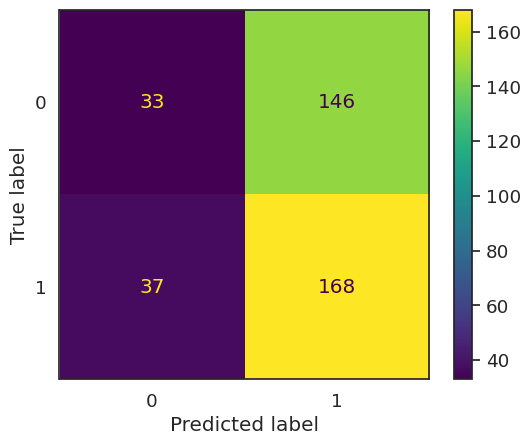

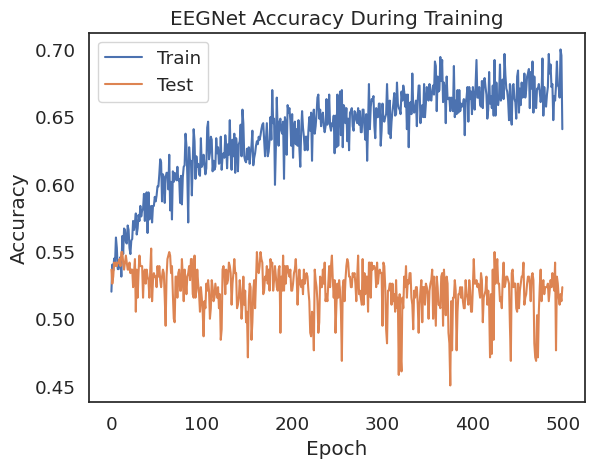

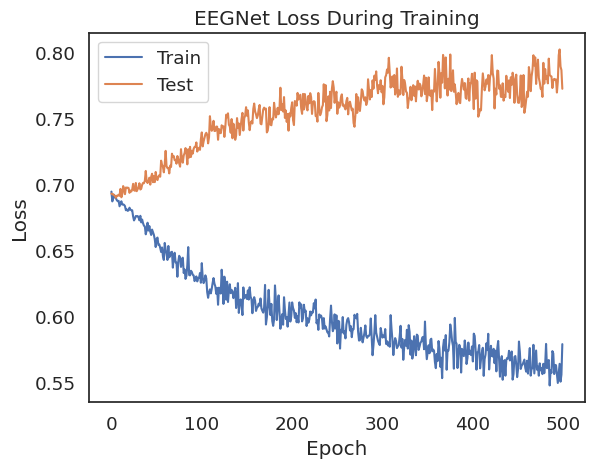

Epoch 1/500
56/56 - 2s - loss: 1.0204 - accuracy: 0.5290 - val_loss: 0.7154 - val_accuracy: 0.5495 - 2s/epoch - 42ms/step
Epoch 2/500
56/56 - 0s - loss: 0.7569 - accuracy: 0.5279 - val_loss: 0.7012 - val_accuracy: 0.5391 - 336ms/epoch - 6ms/step
Epoch 3/500
56/56 - 0s - loss: 0.7490 - accuracy: 0.5312 - val_loss: 0.6934 - val_accuracy: 0.5417 - 392ms/epoch - 7ms/step
Epoch 4/500
56/56 - 0s - loss: 0.7581 - accuracy: 0.5067 - val_loss: 0.6937 - val_accuracy: 0.5651 - 419ms/epoch - 7ms/step
Epoch 5/500
56/56 - 0s - loss: 0.7359 - accuracy: 0.5257 - val_loss: 0.7014 - val_accuracy: 0.5495 - 405ms/epoch - 7ms/step
Epoch 6/500
56/56 - 0s - loss: 0.7322 - accuracy: 0.5112 - val_loss: 0.7000 - val_accuracy: 0.4818 - 315ms/epoch - 6ms/step
Epoch 7/500
56/56 - 0s - loss: 0.7247 - accuracy: 0.5078 - val_loss: 0.7117 - val_accuracy: 0.4766 - 397ms/epoch - 7ms/step
Epoch 8/500
56/56 - 0s - loss: 0.7022 - accuracy: 0.5234 - val_loss: 0.6988 - val_accuracy: 0.5469 - 344ms/epoch - 6ms/step
Epoch 9/50

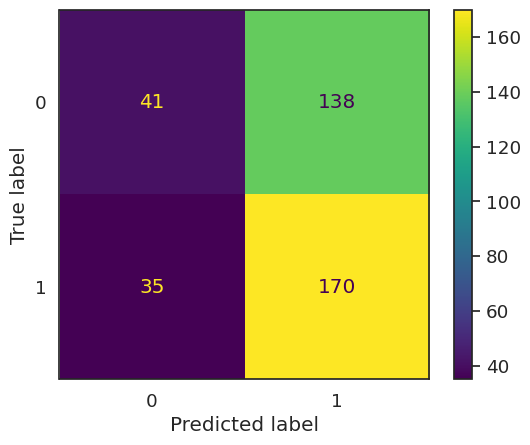

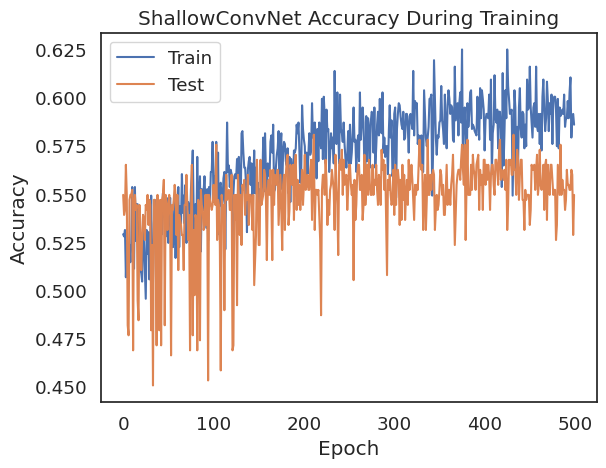

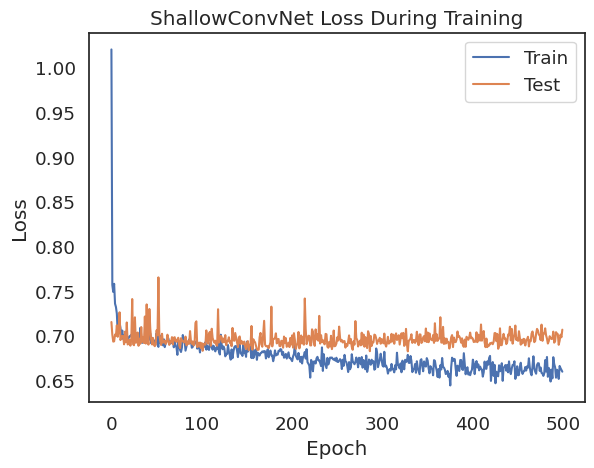

In [ ]:
import tensorflow as tf
# from arl_eegmodels.EEGModels import EEGNet, DeepConvNet, ShallowConvNet
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# To be used for training the model on the opensource dataset

# Train data - 70% of opensource dataset
# Validation data - 30% of opensource dataset
# Test data - data collected from EEG


# Define initial model parameters
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = 'adam'
metrics = ['accuracy']
epochs = 500
channels = num_desired_channels
classes = 2
dropout = 0.25
F1 = 8
F2 = 16
samples = 60

# EEGNet Implementation
model = EEGNet(nb_classes=classes, Chans=num_desired_channels, Samples=samples, dropoutRate=dropout, F1=F1, F2=F2)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
# eeg_net_checkpoint = ModelCheckpoint(filepath='/trained_models/eeg_net_checkpoint.h5', verbose=1, save_best_only=True)

# Fit and train the model
eegnet_history = model.fit(
    delta_x_train, delta_y_train, batch_size=16, epochs=epochs, verbose=2, validation_data=(delta_x_test, delta_y_test)
)

# Evaluate accuracy on test data
probabilities = model.predict(delta_x_test)
predictions = probabilities.argmax(axis=-1)

accuracy = accuracy_score(delta_y_test, predictions)
conf_matrix = confusion_matrix(delta_y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
f1 = f1_score(delta_y_test, predictions)
# roc_auc = roc_auc_score(y_test, probabilities)


print('EEGNet Accuracy Metrics')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
# print(confusion_matrix)
disp.plot()
plt.show()
# print(f'AUC Score: {roc_auc}')

# EEGNet Accuracy Plot
plt.plot(eegnet_history.history['accuracy'])
plt.plot(eegnet_history.history['val_accuracy'])
plt.title('EEGNet Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# EEGNet Loss Plot
plt.plot(eegnet_history.history['loss'])
plt.plot(eegnet_history.history['val_loss'])
plt.title('EEGNet Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()


# ShallowConvNet Implementation
shallow_conv_net_model = ShallowConvNet(nb_classes=classes, Chans=num_desired_channels, Samples=samples, dropoutRate=dropout)
shallow_conv_net_model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
# shallow_conv_net_checkpoint = ModelCheckpoint(
#     filepath='/trained_models/shallow_conv_net_checkpoint.h5', verbose=1, save_best_only=True
# )

# Fit and train the model
shallowconvnet_history = shallow_conv_net_model.fit(
    delta_x_train, delta_y_train, batch_size=16, epochs=epochs, verbose=2, validation_data=(delta_x_test, delta_y_test)
)

# Evaluate accuracy on test data
probabilities = shallow_conv_net_model.predict(delta_x_test)
predictions = probabilities.argmax(axis=-1)

accuracy = accuracy_score(delta_y_test, predictions)
conf_matrix = confusion_matrix(delta_y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
f1 = f1_score(delta_y_test, predictions)
# roc_auc = roc_auc_score(y_test, probabilities)


print('Shallow Conv Net Accuracy Metrics')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
# print(confusion_matrix)
disp.plot()
plt.show()
# print(f'AUC Score: {roc_auc}')

# ShallowConvNet Accuracy Plot
plt.plot(shallowconvnet_history.history['accuracy'])
plt.plot(shallowconvnet_history.history['val_accuracy'])
plt.title('ShallowConvNet Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# ShallowConvNet Loss Plot
plt.plot(shallowconvnet_history.history['loss'])
plt.plot(shallowconvnet_history.history['val_loss'])
plt.title('ShallowConvNet Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

## Theta Classifier

Epoch 1/500
56/56 - 3s - loss: 0.6947 - accuracy: 0.5179 - val_loss: 0.6927 - val_accuracy: 0.5365 - 3s/epoch - 47ms/step
Epoch 2/500
56/56 - 0s - loss: 0.6917 - accuracy: 0.5458 - val_loss: 0.6920 - val_accuracy: 0.5417 - 275ms/epoch - 5ms/step
Epoch 3/500
56/56 - 0s - loss: 0.6880 - accuracy: 0.5536 - val_loss: 0.6913 - val_accuracy: 0.5443 - 311ms/epoch - 6ms/step
Epoch 4/500
56/56 - 0s - loss: 0.6849 - accuracy: 0.5469 - val_loss: 0.6911 - val_accuracy: 0.5391 - 274ms/epoch - 5ms/step
Epoch 5/500
56/56 - 0s - loss: 0.6863 - accuracy: 0.5469 - val_loss: 0.6904 - val_accuracy: 0.5391 - 279ms/epoch - 5ms/step
Epoch 6/500
56/56 - 0s - loss: 0.6856 - accuracy: 0.5547 - val_loss: 0.6915 - val_accuracy: 0.5391 - 268ms/epoch - 5ms/step
Epoch 7/500
56/56 - 0s - loss: 0.6864 - accuracy: 0.5424 - val_loss: 0.6912 - val_accuracy: 0.5469 - 287ms/epoch - 5ms/step
Epoch 8/500
56/56 - 0s - loss: 0.6831 - accuracy: 0.5614 - val_loss: 0.6914 - val_accuracy: 0.5469 - 270ms/epoch - 5ms/step
Epoch 9/50

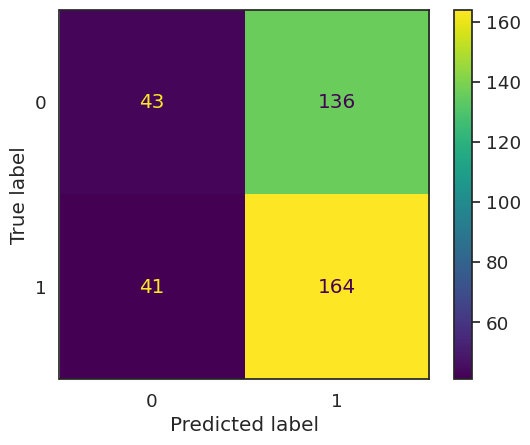

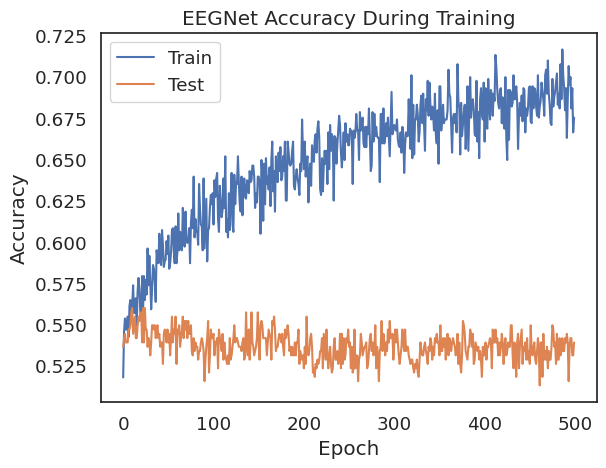

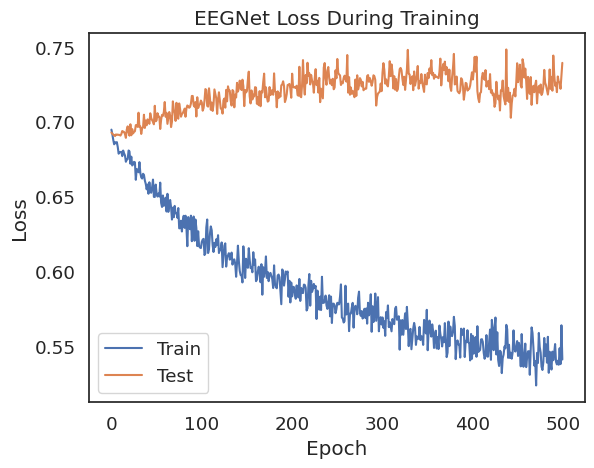

Epoch 1/500
56/56 - 42s - loss: 0.9337 - accuracy: 0.5156 - val_loss: 0.6899 - val_accuracy: 0.5443 - 42s/epoch - 747ms/step
Epoch 2/500
56/56 - 0s - loss: 0.8138 - accuracy: 0.5268 - val_loss: 0.7077 - val_accuracy: 0.5417 - 263ms/epoch - 5ms/step
Epoch 3/500
56/56 - 0s - loss: 0.7728 - accuracy: 0.5112 - val_loss: 0.7163 - val_accuracy: 0.5365 - 266ms/epoch - 5ms/step
Epoch 4/500
56/56 - 0s - loss: 0.7641 - accuracy: 0.5067 - val_loss: 0.7002 - val_accuracy: 0.4896 - 281ms/epoch - 5ms/step
Epoch 5/500
56/56 - 0s - loss: 0.7575 - accuracy: 0.5268 - val_loss: 0.6965 - val_accuracy: 0.5286 - 252ms/epoch - 5ms/step
Epoch 6/500
56/56 - 0s - loss: 0.7378 - accuracy: 0.5145 - val_loss: 0.6920 - val_accuracy: 0.5052 - 266ms/epoch - 5ms/step
Epoch 7/500
56/56 - 0s - loss: 0.7180 - accuracy: 0.5491 - val_loss: 0.6928 - val_accuracy: 0.5339 - 265ms/epoch - 5ms/step
Epoch 8/500
56/56 - 0s - loss: 0.7241 - accuracy: 0.5167 - val_loss: 0.7052 - val_accuracy: 0.4740 - 280ms/epoch - 5ms/step
Epoch 9

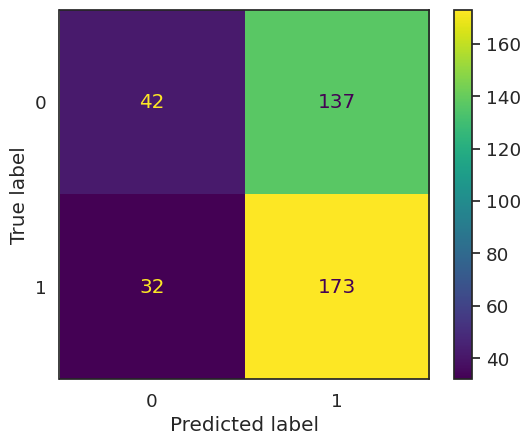

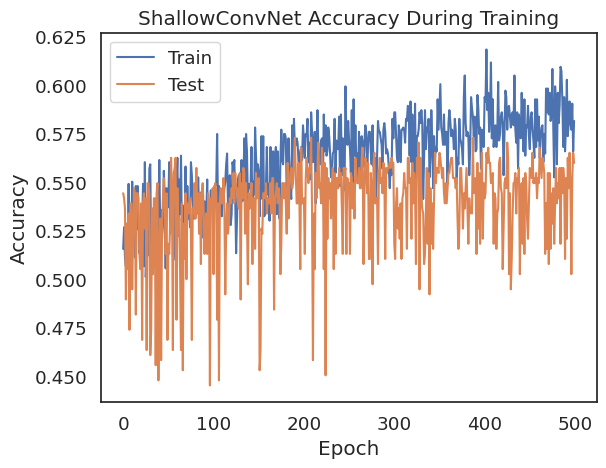

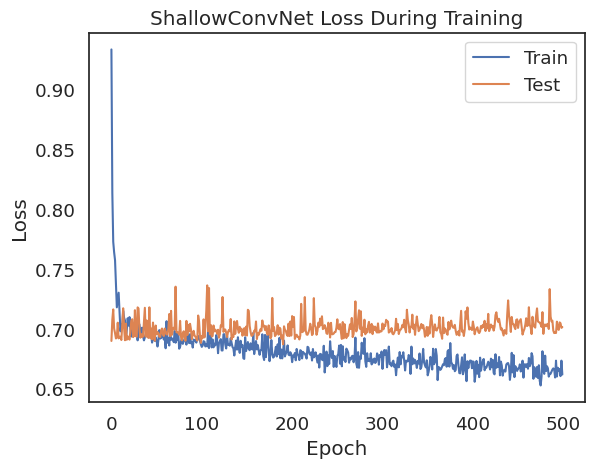

In [ ]:
import tensorflow as tf
# from arl_eegmodels.EEGModels import EEGNet, DeepConvNet, ShallowConvNet
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# To be used for training the model on the opensource dataset

# Train data - 70% of opensource dataset
# Validation data - 30% of opensource dataset
# Test data - data collected from EEG


# Define initial model parameters
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = 'adam'
metrics = ['accuracy']
epochs = 500
channels = num_desired_channels
classes = 2
dropout = 0.25
F1 = 8
F2 = 16
samples = 60

# EEGNet Implementation
model = EEGNet(nb_classes=classes, Chans=num_desired_channels, Samples=samples, dropoutRate=dropout, F1=F1, F2=F2)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
# eeg_net_checkpoint = ModelCheckpoint(filepath='/trained_models/eeg_net_checkpoint.h5', verbose=1, save_best_only=True)

# Fit and train the model
eegnet_history = model.fit(
    theta_x_train, theta_y_train, batch_size=16, epochs=epochs, verbose=2, validation_data=(theta_x_test, theta_y_test)
)

# Evaluate accuracy on test data
probabilities = model.predict(theta_x_test)
predictions = probabilities.argmax(axis=-1)

accuracy = accuracy_score(theta_y_test, predictions)
conf_matrix = confusion_matrix(theta_y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
f1 = f1_score(theta_y_test, predictions)
# roc_auc = roc_auc_score(y_test, probabilities)


print('EEGNet Accuracy Metrics')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
# print(confusion_matrix)
disp.plot()
plt.show()
# print(f'AUC Score: {roc_auc}')

# EEGNet Accuracy Plot
plt.plot(eegnet_history.history['accuracy'])
plt.plot(eegnet_history.history['val_accuracy'])
plt.title('EEGNet Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# EEGNet Loss Plot
plt.plot(eegnet_history.history['loss'])
plt.plot(eegnet_history.history['val_loss'])
plt.title('EEGNet Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()


# ShallowConvNet Implementation
shallow_conv_net_model = ShallowConvNet(nb_classes=classes, Chans=num_desired_channels, Samples=samples, dropoutRate=dropout)
shallow_conv_net_model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
# shallow_conv_net_checkpoint = ModelCheckpoint(
#     filepath='/trained_models/shallow_conv_net_checkpoint.h5', verbose=1, save_best_only=True
# )

# Fit and train the model
shallowconvnet_history = shallow_conv_net_model.fit(
    theta_x_train, theta_y_train, batch_size=16, epochs=epochs, verbose=2, validation_data=(theta_x_test, theta_y_test)
)

# Evaluate accuracy on test data
probabilities = shallow_conv_net_model.predict(theta_x_test)
predictions = probabilities.argmax(axis=-1)

accuracy = accuracy_score(theta_y_test, predictions)
conf_matrix = confusion_matrix(theta_y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
f1 = f1_score(theta_y_test, predictions)
# roc_auc = roc_auc_score(y_test, probabilities)


print('Shallow Conv Net Accuracy Metrics')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
# print(confusion_matrix)
disp.plot()
plt.show()
# print(f'AUC Score: {roc_auc}')

# ShallowConvNet Accuracy Plot
plt.plot(shallowconvnet_history.history['accuracy'])
plt.plot(shallowconvnet_history.history['val_accuracy'])
plt.title('ShallowConvNet Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# ShallowConvNet Loss Plot
plt.plot(shallowconvnet_history.history['loss'])
plt.plot(shallowconvnet_history.history['val_loss'])
plt.title('ShallowConvNet Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

## Alpha Classifier

Epoch 1/500
56/56 - 3s - loss: 0.7052 - accuracy: 0.4888 - val_loss: 0.6922 - val_accuracy: 0.5260 - 3s/epoch - 47ms/step
Epoch 2/500
56/56 - 0s - loss: 0.6961 - accuracy: 0.5346 - val_loss: 0.6919 - val_accuracy: 0.5312 - 338ms/epoch - 6ms/step
Epoch 3/500
56/56 - 0s - loss: 0.6890 - accuracy: 0.5335 - val_loss: 0.6915 - val_accuracy: 0.5339 - 442ms/epoch - 8ms/step
Epoch 4/500
56/56 - 0s - loss: 0.6880 - accuracy: 0.5379 - val_loss: 0.6908 - val_accuracy: 0.5391 - 368ms/epoch - 7ms/step
Epoch 5/500
56/56 - 0s - loss: 0.6938 - accuracy: 0.5290 - val_loss: 0.6912 - val_accuracy: 0.5365 - 425ms/epoch - 8ms/step
Epoch 6/500
56/56 - 0s - loss: 0.6902 - accuracy: 0.5268 - val_loss: 0.6908 - val_accuracy: 0.5365 - 444ms/epoch - 8ms/step
Epoch 7/500
56/56 - 0s - loss: 0.6885 - accuracy: 0.5312 - val_loss: 0.6903 - val_accuracy: 0.5443 - 441ms/epoch - 8ms/step
Epoch 8/500
56/56 - 0s - loss: 0.6886 - accuracy: 0.5458 - val_loss: 0.6908 - val_accuracy: 0.5469 - 439ms/epoch - 8ms/step
Epoch 9/50

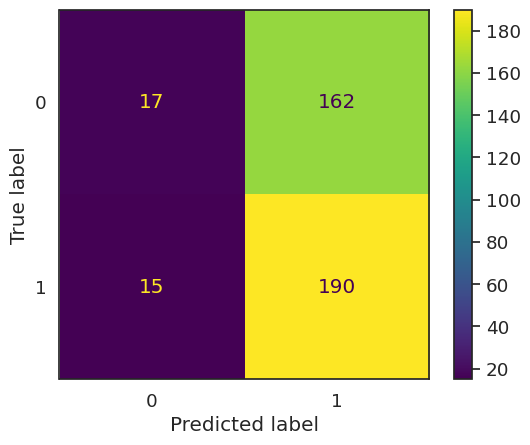

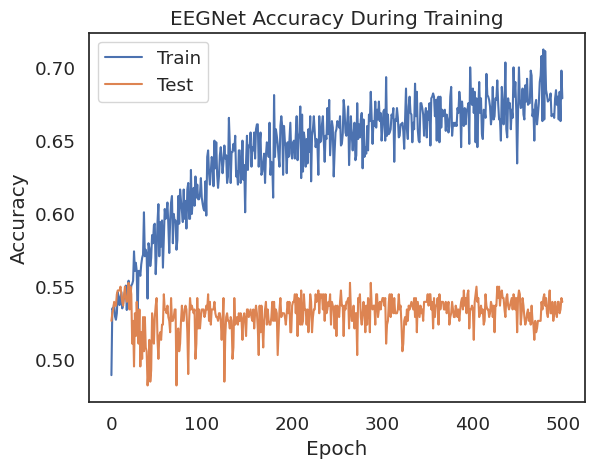

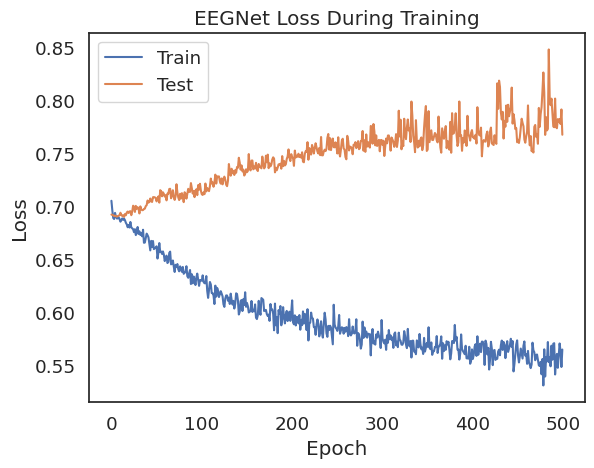

Epoch 1/500
56/56 - 2s - loss: 1.1596 - accuracy: 0.4844 - val_loss: 0.7349 - val_accuracy: 0.5339 - 2s/epoch - 33ms/step
Epoch 2/500
56/56 - 0s - loss: 0.8171 - accuracy: 0.4900 - val_loss: 0.7032 - val_accuracy: 0.4844 - 246ms/epoch - 4ms/step
Epoch 3/500
56/56 - 0s - loss: 0.7914 - accuracy: 0.5000 - val_loss: 0.6956 - val_accuracy: 0.5469 - 267ms/epoch - 5ms/step
Epoch 4/500
56/56 - 0s - loss: 0.7606 - accuracy: 0.5067 - val_loss: 0.7012 - val_accuracy: 0.5391 - 256ms/epoch - 5ms/step
Epoch 5/500
56/56 - 0s - loss: 0.7799 - accuracy: 0.4888 - val_loss: 0.6949 - val_accuracy: 0.5312 - 275ms/epoch - 5ms/step
Epoch 6/500
56/56 - 0s - loss: 0.7325 - accuracy: 0.5257 - val_loss: 0.7065 - val_accuracy: 0.4922 - 255ms/epoch - 5ms/step
Epoch 7/500
56/56 - 0s - loss: 0.7228 - accuracy: 0.5123 - val_loss: 0.6998 - val_accuracy: 0.4948 - 329ms/epoch - 6ms/step
Epoch 8/500
56/56 - 0s - loss: 0.7153 - accuracy: 0.5290 - val_loss: 0.7494 - val_accuracy: 0.4531 - 400ms/epoch - 7ms/step
Epoch 9/50

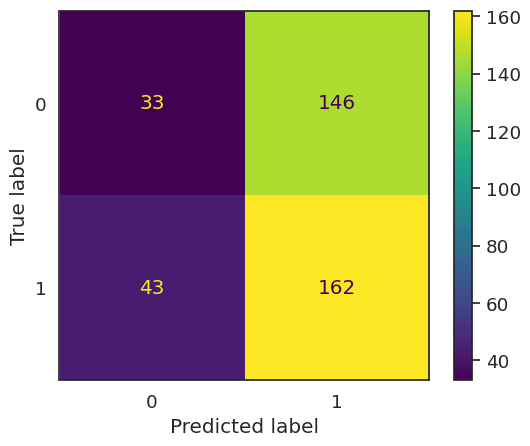

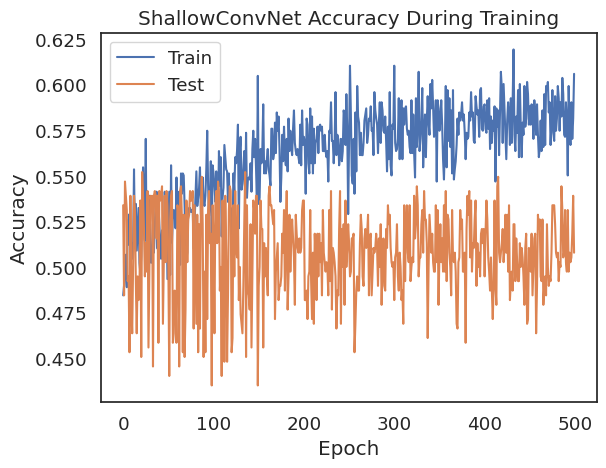

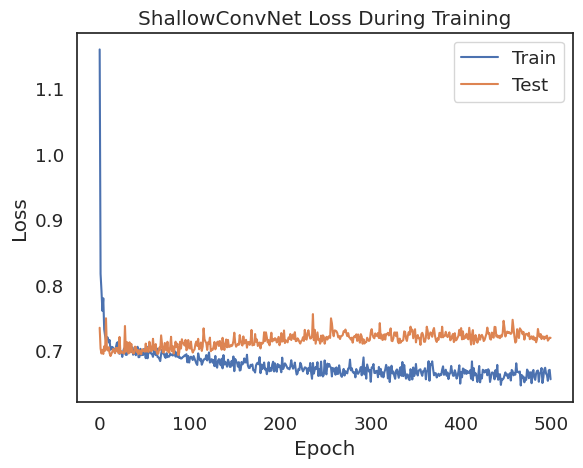

In [ ]:
import tensorflow as tf
# from arl_eegmodels.EEGModels import EEGNet, DeepConvNet, ShallowConvNet
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# To be used for training the model on the opensource dataset

# Train data - 70% of opensource dataset
# Validation data - 30% of opensource dataset
# Test data - data collected from EEG


# Define initial model parameters
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = 'adam'
metrics = ['accuracy']
epochs = 500
channels = num_desired_channels
classes = 2
dropout = 0.25
F1 = 8
F2 = 16
samples = 60

# EEGNet Implementation
model = EEGNet(nb_classes=classes, Chans=num_desired_channels, Samples=samples, dropoutRate=dropout, F1=F1, F2=F2)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
# eeg_net_checkpoint = ModelCheckpoint(filepath='/trained_models/eeg_net_checkpoint.h5', verbose=1, save_best_only=True)

# Fit and train the model
eegnet_history = model.fit(
    alpha_x_train, alpha_y_train, batch_size=16, epochs=epochs, verbose=2, validation_data=(alpha_x_test, alpha_y_test)
)

# Evaluate accuracy on test data
probabilities = model.predict(alpha_x_test)
predictions = probabilities.argmax(axis=-1)

accuracy = accuracy_score(alpha_y_test, predictions)
conf_matrix = confusion_matrix(alpha_y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
f1 = f1_score(alpha_y_test, predictions)
# roc_auc = roc_auc_score(y_test, probabilities)


print('EEGNet Accuracy Metrics')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
# print(confusion_matrix)
disp.plot()
plt.show()
# print(f'AUC Score: {roc_auc}')

# EEGNet Accuracy Plot
plt.plot(eegnet_history.history['accuracy'])
plt.plot(eegnet_history.history['val_accuracy'])
plt.title('EEGNet Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# EEGNet Loss Plot
plt.plot(eegnet_history.history['loss'])
plt.plot(eegnet_history.history['val_loss'])
plt.title('EEGNet Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()


# ShallowConvNet Implementation
shallow_conv_net_model = ShallowConvNet(nb_classes=classes, Chans=num_desired_channels, Samples=samples, dropoutRate=dropout)
shallow_conv_net_model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
# shallow_conv_net_checkpoint = ModelCheckpoint(
#     filepath='/trained_models/shallow_conv_net_checkpoint.h5', verbose=1, save_best_only=True
# )

# Fit and train the model
shallowconvnet_history = shallow_conv_net_model.fit(
    alpha_x_train, alpha_y_train, batch_size=16, epochs=epochs, verbose=2, validation_data=(alpha_x_test, alpha_y_test)
)

# Evaluate accuracy on test data
probabilities = shallow_conv_net_model.predict(alpha_x_test)
predictions = probabilities.argmax(axis=-1)

accuracy = accuracy_score(alpha_y_test, predictions)
conf_matrix = confusion_matrix(alpha_y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
f1 = f1_score(alpha_y_test, predictions)
# roc_auc = roc_auc_score(y_test, probabilities)


print('Shallow Conv Net Accuracy Metrics')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
# print(confusion_matrix)
disp.plot()
plt.show()
# print(f'AUC Score: {roc_auc}')

# ShallowConvNet Accuracy Plot
plt.plot(shallowconvnet_history.history['accuracy'])
plt.plot(shallowconvnet_history.history['val_accuracy'])
plt.title('ShallowConvNet Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# ShallowConvNet Loss Plot
plt.plot(shallowconvnet_history.history['loss'])
plt.plot(shallowconvnet_history.history['val_loss'])
plt.title('ShallowConvNet Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

## Beta Classifier

Epoch 1/500
56/56 - 3s - loss: 0.6968 - accuracy: 0.5078 - val_loss: 0.6923 - val_accuracy: 0.5573 - 3s/epoch - 48ms/step
Epoch 2/500
56/56 - 0s - loss: 0.6896 - accuracy: 0.5357 - val_loss: 0.6914 - val_accuracy: 0.5339 - 282ms/epoch - 5ms/step
Epoch 3/500
56/56 - 0s - loss: 0.6934 - accuracy: 0.5179 - val_loss: 0.6908 - val_accuracy: 0.5339 - 285ms/epoch - 5ms/step
Epoch 4/500
56/56 - 0s - loss: 0.6890 - accuracy: 0.5435 - val_loss: 0.6902 - val_accuracy: 0.5339 - 282ms/epoch - 5ms/step
Epoch 5/500
56/56 - 0s - loss: 0.6907 - accuracy: 0.5246 - val_loss: 0.6905 - val_accuracy: 0.5339 - 271ms/epoch - 5ms/step
Epoch 6/500
56/56 - 0s - loss: 0.6872 - accuracy: 0.5491 - val_loss: 0.6898 - val_accuracy: 0.5391 - 269ms/epoch - 5ms/step
Epoch 7/500
56/56 - 0s - loss: 0.6853 - accuracy: 0.5569 - val_loss: 0.6911 - val_accuracy: 0.5417 - 278ms/epoch - 5ms/step
Epoch 8/500
56/56 - 0s - loss: 0.6878 - accuracy: 0.5547 - val_loss: 0.6910 - val_accuracy: 0.5312 - 285ms/epoch - 5ms/step
Epoch 9/50

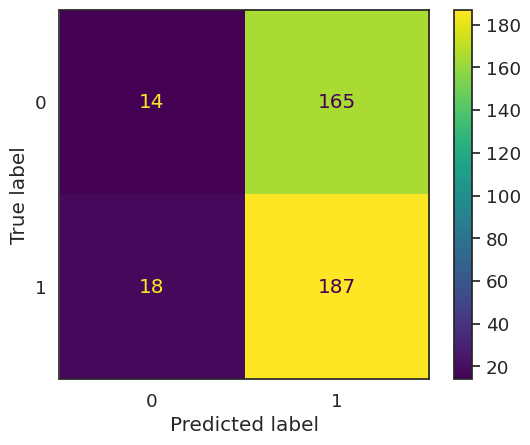

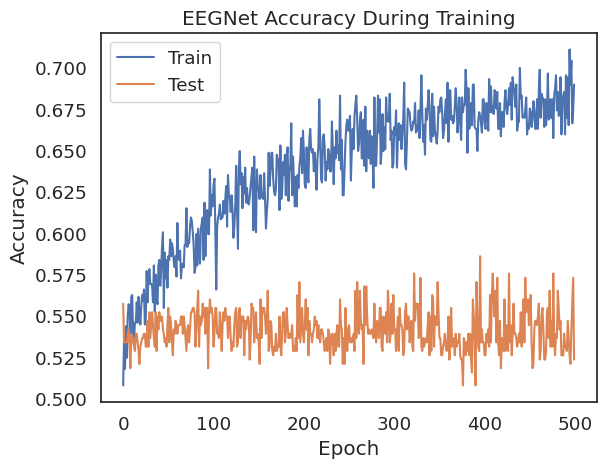

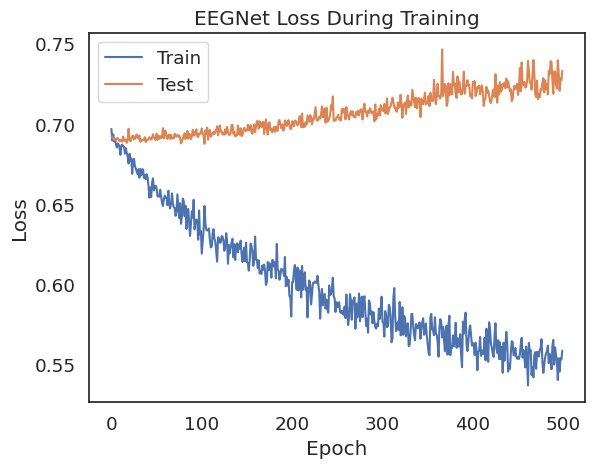

Epoch 1/500
56/56 - 2s - loss: 0.8267 - accuracy: 0.5067 - val_loss: 0.7260 - val_accuracy: 0.5234 - 2s/epoch - 40ms/step
Epoch 2/500
56/56 - 0s - loss: 0.7796 - accuracy: 0.4877 - val_loss: 0.7045 - val_accuracy: 0.5156 - 397ms/epoch - 7ms/step
Epoch 3/500
56/56 - 0s - loss: 0.7504 - accuracy: 0.5402 - val_loss: 0.6949 - val_accuracy: 0.5521 - 335ms/epoch - 6ms/step
Epoch 4/500
56/56 - 0s - loss: 0.7319 - accuracy: 0.5145 - val_loss: 0.7152 - val_accuracy: 0.4635 - 401ms/epoch - 7ms/step
Epoch 5/500
56/56 - 0s - loss: 0.7114 - accuracy: 0.5458 - val_loss: 0.7991 - val_accuracy: 0.5312 - 445ms/epoch - 8ms/step
Epoch 6/500
56/56 - 0s - loss: 0.7416 - accuracy: 0.5212 - val_loss: 0.7238 - val_accuracy: 0.5312 - 415ms/epoch - 7ms/step
Epoch 7/500
56/56 - 0s - loss: 0.7218 - accuracy: 0.5246 - val_loss: 0.7004 - val_accuracy: 0.5156 - 431ms/epoch - 8ms/step
Epoch 8/500
56/56 - 0s - loss: 0.7254 - accuracy: 0.5179 - val_loss: 0.7078 - val_accuracy: 0.5286 - 343ms/epoch - 6ms/step
Epoch 9/50

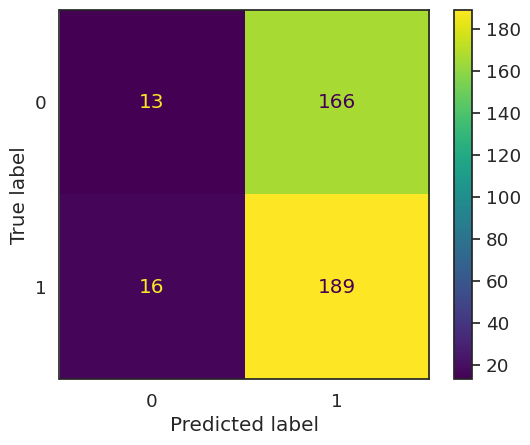

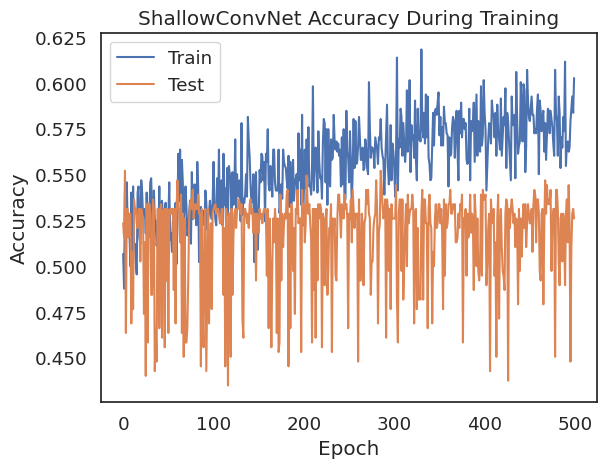

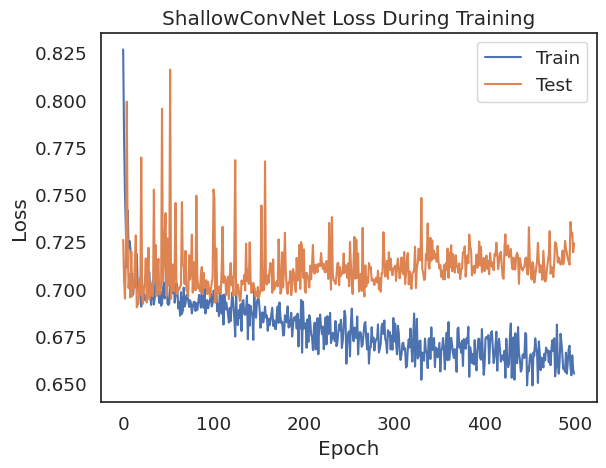

In [ ]:
import tensorflow as tf
# from arl_eegmodels.EEGModels import EEGNet, DeepConvNet, ShallowConvNet
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# To be used for training the model on the opensource dataset

# Train data - 70% of opensource dataset
# Validation data - 30% of opensource dataset
# Test data - data collected from EEG


# Define initial model parameters
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = 'adam'
metrics = ['accuracy']
epochs = 500
channels = num_desired_channels
classes = 2
dropout = 0.25
F1 = 8
F2 = 16
samples = 60

# EEGNet Implementation
model = EEGNet(nb_classes=classes, Chans=num_desired_channels, Samples=samples, dropoutRate=dropout, F1=F1, F2=F2)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
# eeg_net_checkpoint = ModelCheckpoint(filepath='/trained_models/eeg_net_checkpoint.h5', verbose=1, save_best_only=True)

# Fit and train the model
eegnet_history = model.fit(
    beta_x_train, beta_y_train, batch_size=16, epochs=epochs, verbose=2, validation_data=(beta_x_test, beta_y_test)
)

# Evaluate accuracy on test data
probabilities = model.predict(beta_x_test)
predictions = probabilities.argmax(axis=-1)

accuracy = accuracy_score(beta_y_test, predictions)
conf_matrix = confusion_matrix(beta_y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
f1 = f1_score(beta_y_test, predictions)
# roc_auc = roc_auc_score(y_test, probabilities)


print('EEGNet Accuracy Metrics')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
# print(confusion_matrix)
disp.plot()
plt.show()
# print(f'AUC Score: {roc_auc}')

# EEGNet Accuracy Plot
plt.plot(eegnet_history.history['accuracy'])
plt.plot(eegnet_history.history['val_accuracy'])
plt.title('EEGNet Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# EEGNet Loss Plot
plt.plot(eegnet_history.history['loss'])
plt.plot(eegnet_history.history['val_loss'])
plt.title('EEGNet Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()


# ShallowConvNet Implementation
shallow_conv_net_model = ShallowConvNet(nb_classes=classes, Chans=num_desired_channels, Samples=samples, dropoutRate=dropout)
shallow_conv_net_model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
# shallow_conv_net_checkpoint = ModelCheckpoint(
#     filepath='/trained_models/shallow_conv_net_checkpoint.h5', verbose=1, save_best_only=True
# )

# Fit and train the model
shallowconvnet_history = shallow_conv_net_model.fit(
    beta_x_train, beta_y_train, batch_size=16, epochs=epochs, verbose=2, validation_data=(beta_x_test, beta_y_test)
)

# Evaluate accuracy on test data
probabilities = shallow_conv_net_model.predict(beta_x_test)
predictions = probabilities.argmax(axis=-1)

accuracy = accuracy_score(beta_y_test, predictions)
conf_matrix = confusion_matrix(beta_y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
f1 = f1_score(beta_y_test, predictions)
# roc_auc = roc_auc_score(y_test, probabilities)


print('Shallow Conv Net Accuracy Metrics')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
# print(confusion_matrix)
disp.plot()
plt.show()
# print(f'AUC Score: {roc_auc}')

# ShallowConvNet Accuracy Plot
plt.plot(shallowconvnet_history.history['accuracy'])
plt.plot(shallowconvnet_history.history['val_accuracy'])
plt.title('ShallowConvNet Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# ShallowConvNet Loss Plot
plt.plot(shallowconvnet_history.history['loss'])
plt.plot(shallowconvnet_history.history['val_loss'])
plt.title('ShallowConvNet Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()